# Search template

We give the general search template for our jigsaw puzzle solver. We'll use this template with our models trained for solving the checking_left_right_adjacency problem

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import os
from itertools import product

import pprint
import itertools
from collections import defaultdict
import copy

# generate random integer values
import random
from random import seed
from random import randint
import numpy as np
from pylab import array
from random import sample
import math

from Puzzle_generator import *
from Checking_adjacency_dataset import *
from FromScratch_CNN import *
from ResNetFT_Finetuning import *
from Training_template import *
from Adjacency_distance import *

import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils
from torch import nn, optim
from torchvision import datasets, transforms
#from torchvision.utils import make_grid

# Recap

## The puzzle

We generate puzzles from the CUB-200 dataset images by cutting up each image into square pieces and randomly rotating each piece by 0, 90, 180 or 270 degrees counterclockwise and shuffling up the pieces


## What we have so far

We are given a list of the shuffled pieces, the size of the puzzle board, the correct top-left-corner piece and orientation. Further, given a tuple of square puzzle pieces (P,Q), we have models which give a _score_ for (P,Q) being left-right adjacent. We interpet the scores as follows : _Higher the score, higher the confidence that the model has about (P,Q) being _left-right-adjacent__




# An overview of the search

## The broad plan 
The plan for putting the puzzle pieces back together is broadly as follows:

* We are given the shuffled pieces, the size of the puzzle board and also the top left corner piece in its correct orientation


* We construct a puzzle board, which at any given point of time, has some open and empty slots, some filled and closed slots, and some slots which are empty but closed (i.e, we cannot fill up those slots just yet).


* We __search__ for a __best-fitting__ (piece, orientation, open slot) combination  (say (P,R,O)) from the remaining puzzle pieces and open slots


* We fit P after orienting it (apropos R) in open slot O


* Each time an open slot is filled, it becomes filled and closed. Further, the empty slots ajacent to it open up


* We keep updating the puzzle board by fitting puzzle pieces in its open slots until the board is completely filled 


## Finding the best (piece, orientation, open_slot)


Given a puzzle board in a particular state, we use our models which check left_right_adjacency to determine the _best_ (piece, orientation, open_slot) combination for the board in the given state as follows:

  For each remaining_piece P, orientation R and open_slot O, we'll compute a __compatiblity_score(P,R,O)__ which is the average of the __adjacency_score__(N, P) for each filled neighbour N of slot O 
  
  
  __NB__ : _We of course have to compute the adjacency_score(N, P) by rotating P, N appropriately  so that  adjacency_score(P,N) = left_right_adjacency_score(modified_N, modified_P)_ 
  
  We then choose the triple (P,R,O) with the highest compatibility score as the __best-fit__ combination 


## Initial board and move

We start with an empty puzzle board of the correct dimensions where only the top-left corner is open. The rest of the slots are closed. For our first move, we fit the given top-left-corner piece in its correct orientation






# Helper functions

In [2]:
def transform_puzzle_input(piece_1, piece_2, model_dim=224):
        width = model_dim
        height = model_dim
        piece_1 = piece_1.resize((width, height))
        piece_2 = piece_2.resize((width, height))
        juxtaposed = Image.new('RGB', (2*width, height), color=0)
        #juxtaposed.paste(piece_i ,(left_upper_row, left_upper_col,right_lower_row, right_lower_col))
        juxtaposed.paste(piece_1,(0,0,width, height))
        juxtaposed.paste(piece_2,(width,0,2*width, height))
        juxtaposed = juxtaposed.crop((width//2, 0,width//2 + width,height))
        return transforms.ToTensor()(juxtaposed)
    

In [3]:
def left_right_adj_score(P, Q, R, S, model_name, model):   
    #rotate Puzzle piece P by 90R degrees clockwise
    #rotate Puzzle piece Q by 90S degrees clockwise
    #model(P,Q)
    piece_1 = Image.fromarray(P, 'RGB').rotate(-90*R)
    piece_2 = Image.fromarray(Q, 'RGB').rotate(-90*S)
    
    with torch.no_grad():
            juxtaposed_pieces_torchtensor = transform_puzzle_input(piece_1, piece_2)
            new_input_torchtensor = juxtaposed_pieces_torchtensor.unsqueeze(0)
            if model_name=="AdjacencyClassifier_NoML":
                score = model.negative_distance_score(new_input_torchtensor).numpy()
                return score[0]
            elif model_name=="Dummy":
                return random.random()
            else:
                score = model(new_input_torchtensor).numpy()
                return score[0,1]
                



To avoid duplication of computation of left_right_adj_scores while solving the puzzle, whenever we compute left_right_adj_score(P, Q, R, S,..), we'll store the results in a dictionary __information_dict__

More precisely, information_dict will contain key-value pairs of the form

* key = (piece_P_position, orientation R)
* value = a dictionary with key value pairs piece_Q_position : <pre>{0: s_0, 1: s_1, 2, s_2, 3: s_3}</pre> where s_i is left_right_adj_score(P,Q,R,i)

Thus information_dict looks like

    {(piece_P_position, orientation R): { piece_Q_position : {0: s_0, 1: s_1, 2, s_2, 3: s_3 } .. } ... }


In [4]:
def compute_and_memoize_score(information_dict, shuffled_puzzle_pieces_np, P, Q, R, S, model_name, model):
    N = len(shuffled_puzzle_pieces_np)
    if ((P,R) not in information_dict):
        information_dict[(P,R)] = {Q: {}}
    elif (Q not in information_dict[(P,R)]):
        information_dict[(P,R)][Q] = {}
    if S not in information_dict[(P,R)][Q]:
        information_dict[(P,R)][Q][S] = left_right_adj_score(shuffled_puzzle_pieces_np[P], 
                                                             shuffled_puzzle_pieces_np[Q], 
                                                             R, S, model_name, model)
        R_ = (R + 2) % 4
        S_ = (S + 2) % 4
        if ((Q,S_) not in information_dict):
            information_dict[(Q,S_)] = {P: {}}
        elif (P not in information_dict[(Q,S_)]):
            information_dict[(Q,S_)][P] = {}
        assert(R_ not in information_dict[(Q,S_)][P]),"Symmetric entry already computed unexpectedly"
        information_dict[(Q,S_)][P][R_] = information_dict[(P,R)][Q][S]
    return information_dict[(P,R)][Q][S]




# The puzzle board class

We will define a python class called PuzzleBoard  



## Main attributes of PuzzleBoard


* __rows__ = number of rows of the puzzle board
* __cols__ = number of rows of the puzzle board
* __open_slots__ =  set of tuples (i,j) which are the open and empty slots in the puzzle board
* __available_pieces__ = set of positions of unfitted pieces
* __filled_slots__ = set of filled slots
* __state__ = the current state of the puzzle board. We will explain below what constitutes the state of the board
* __predicted_new_to_old_dict__ = a dictionary with key value pairs 
        
        new label of a piece: (predicted old label of a piece, predicted orientation)
                
* __top_left_piece_new_label__ = the new label of the original top left piece

* __top_left_piece_orientation__ = the orientation of the original top left piece

* __shuffled_puzzle_pieces_np__ = the list of shuffled pieces stored as numpy arrays

* __model_name__ = the name of the model that we are using in the solver

* __model__ = the model that we are using in the solver


        

### State of the board

The state of the board is stored as a dictionary where the keys are tuples (i,j) referring to slots (open/filled) in the board. The value of the key (i,j) stores information about any neighbours of the slot. More precisely, the key value pairs of the state look like

<pre> (i,j) : [(nbhr_0, rotation_of_nbhr_0),(nbhr_1, rotation_of_nbhr_1), 
               (nbhr_2, rotation_of_nbhr_2),(nbhr_3, rotation_of_nbhr_3)] </pre>
  

where 

<ul>
    <li>Neighbour 0 of a piece =  its left neighbour </li>
    <li>Neighbour 1 of a piece = its top neighbour </li>
    <li>Neighbour 2 of a piece = its right neighbour</li>
    <li>Neighbour 3 of a piece = its bottom neighbour</li>
</ul>


<i> If there is no neighbour i for a piece, then entry for neighbour i is (None, None)</i>


## Main methods of PuzzleBoard

It will support the following methods

* __fit_top_left_corner__ : fits the given top left piece

* __find_best_fit__ : find the best (piece, orientation, open_slot) to fit 

* __fit__ : fits the given (piece, orientation, open_slot)

* __display__ : displays the puzzle board in its current state

## Code

In [5]:
class PuzzleBoard:

    def __init__(self, rows, cols, information_dict, top_left_piece_new_label, 
                 top_left_piece_orientation, shuffled_puzzle_pieces_np, model_name, model):
        self.rows = rows
        self.cols = cols
        self.information_dict = information_dict
        self.available_pieces = set(range(len(shuffled_puzzle_pieces_np)))
        self.filled_slots = set()
        self.open_slots = {(0,0)}
        self.state = {}
        for i in range(self.rows):
            for j in range(self.cols):
                self.state[(i,j)] = [(None, None), 
                                     (None, None),
                                     (None, None), 
                                     (None, None)]
        self.predicted_new_to_old_dict = {}
        self.top_left_piece_new_label = top_left_piece_new_label
        self.top_left_piece_orientation  = top_left_piece_orientation
        self.match = {0:2, 1:3, 2:0, 3:1}
        self.shuffled_puzzle_pieces_np = shuffled_puzzle_pieces_np
        self.model_name=model_name
        self.model=model
                
    def display(self, puzzle_square_piece_dim):
        display_solved_puzzle(self.rows, self.cols,puzzle_square_piece_dim, 
                              self.shuffled_puzzle_pieces_np, self.predicted_new_to_old_dict)
        
        
    def fit(self, current_piece_pos, current_rotation, current_open_slot):
        self.open_slots.remove(current_open_slot)
        
        current_piece_new_label = self.pos_to_new_label(current_piece_pos)
        self.predicted_new_to_old_dict[current_piece_new_label] = (*current_open_slot, current_rotation)
        
        for i, nbhr_slot in enumerate(self.neighbour_slots(current_open_slot)):
            if nbhr_slot is not None:
                self.state[nbhr_slot][self.match[i]] = (current_piece_pos, current_rotation)
                if nbhr_slot not in self.filled_slots:
                    self.open_slots.add(nbhr_slot)
                    
        self.available_pieces.remove(current_piece_pos)
        self.filled_slots.add(current_open_slot)

        
       
            
        
    def fit_top_left_corner(self):
        top_left_piece_pos = self.new_label_to_pos(self.top_left_piece_new_label)
        self.fit(top_left_piece_pos, self.top_left_piece_orientation, (0,0))
        
        
    def find_best_fit(self):
        candidate_open_slot = None
        candidate_pos = None
        candidate_rotation = None
        best_score = -math.inf
        for open_slot in self.open_slots:
            for current_piece_pos in self.available_pieces:
                for current_rotation in [0,1,2,3]:
                    sum_of_scores = 0
                    no_of_nbhrs = 0
                    for i in range(4):
                        if self.state[open_slot][i][0] is not None:
                            nbhr = self.state[open_slot][i][0]
                            nbhr_rotation = self.state[open_slot][i][1]
                            NR_ = (nbhr_rotation-i) % 4
                            R_ = (current_rotation-i) % 4
                            current_score = compute_and_memoize_score(self.information_dict,
                                                                      self.shuffled_puzzle_pieces_np,
                                                                      nbhr,current_piece_pos,
                                                                      NR_,R_,self.model_name,self.model)
                            sum_of_scores += current_score
                            no_of_nbhrs += 1
                    if no_of_nbhrs > 0:
                        score = sum_of_scores/no_of_nbhrs
                    else: 
                        score = 0

                    if score > best_score:
                        candidate_pos = current_piece_pos
                        candidate_rotation = current_rotation
                        candidate_open_slot = open_slot
                        best_score = score
                        
        return (candidate_pos, candidate_rotation, candidate_open_slot)        
        
    ##Helper methods
    
    def neighbour_slots(self, slot):
        p, q = slot
        nbhr_slots = [None, None, None, None]
        nbhr_slots_candidates = [(p,q-1), (p-1,q), (p,q+1), (p+1,q)]
        for i in range(4):
            a,b = nbhr_slots_candidates[i]
            if a>=0 and a< self.rows and b>=0 and b< self.cols:
                nbhr_slots[i] = nbhr_slots_candidates[i]
        return nbhr_slots
    
        
    def new_label_to_pos(self, new_label):
        return new_label[0]*self.cols + new_label[1]

    def pos_to_new_label(self, pos):
        return (pos//self.cols, (pos % self.cols))
    
    



# Solver functions

In [6]:
def solve_puzzle(rows, cols, top_left_piece_new_label, top_left_piece_orientation,
                 shuffled_puzzle_pieces_np, puzzle_square_piece_dim, model_name, model,
                 show_solving_progress) :
    

    N = len(shuffled_puzzle_pieces_np)
    information_dict = {}
    my_board = PuzzleBoard(rows, cols, information_dict, top_left_piece_new_label, 
                           top_left_piece_orientation,
                           shuffled_puzzle_pieces_np,model_name, model)
    my_board.fit_top_left_corner()
    if show_solving_progress:
        my_board.display(puzzle_square_piece_dim)
    no_of_slots_left =  rows*cols-1
    
    for counter in range(no_of_slots_left):
        candidate = my_board.find_best_fit() 
        my_board.fit(*candidate)
        if show_solving_progress:
            my_board.display(puzzle_square_piece_dim)

    return my_board

In [7]:
def display_solved_puzzle(rows, cols,puzzle_square_piece_dim, shuffled_puzzle_pieces_np, predicted_new_to_old_dict):
    my_dpi = 100 #font size + line thickness
    fig = plt.figure(dpi = my_dpi)
    
    puzzle_piece_length = puzzle_square_piece_dim
    puzzle_piece_width = puzzle_square_piece_dim
    new_image_length = rows*puzzle_piece_length
    new_image_width = cols*puzzle_piece_width
    
    
    solved_image = Image.new('RGB', (new_image_length,new_image_width), color="white")
    for pos, piece in enumerate(shuffled_puzzle_pieces_np):
        new_x, new_y = (pos//cols, (pos % cols))
        if (new_x, new_y) in predicted_new_to_old_dict:
            old_x, old_y, r = predicted_new_to_old_dict[(new_x, new_y)]
            img_of_piece = Image.fromarray(piece, 'RGB').rotate(-90*r)
            solved_image.paste(img_of_piece,(old_y*puzzle_piece_width,old_x*puzzle_piece_length,(old_y+1)*puzzle_piece_width,(old_x+1)*puzzle_piece_length))
           

 
    ax=fig.add_subplot(1,1,1)
    # Add the original image
    ax.imshow(solved_image)
    plt.show()



In [8]:
def solve_example(file_name, puzzle_square_piece_dim,model_name, model, show_solving_progress=False,input_display=False):
    print(f"Solving {file_name}...")
    input = get_puzzle_pieces(file_name,puzzle_square_piece_dim, input_display)
    rows = input[0]
    cols = input[1] 
    top_left_piece_new_label = input[2] 
    top_left_piece_orientation = input[3] 
    new_to_old_label_dict = input[4]
    shuffled_puzzle_pieces_np = input[5]
    board = solve_puzzle(rows, cols,top_left_piece_new_label,top_left_piece_orientation, 
                         shuffled_puzzle_pieces_np, puzzle_square_piece_dim,model_name, model,show_solving_progress)
    print("*****************")
    print(f"Solved puzzle using {model_name} solver")
    board.display(puzzle_square_piece_dim)    
    information_dict = board.information_dict
    predicted_new_to_old_dict = board.predicted_new_to_old_dict
    #display_solved_puzzle(rows, cols, puzzle_square_piece_dim, shuffled_puzzle_pieces_np, new_to_old_label_dict)
    correct_position = 0
    correct_position_and_rotation = 0
    for k in new_to_old_label_dict:
        if new_to_old_label_dict[k][:2] == predicted_new_to_old_dict[k][:2]:
            correct_position += 1
            if new_to_old_label_dict[k][2] == predicted_new_to_old_dict[k][2]:
                correct_position_and_rotation += 1
    print("*******************")
    print(f"In correct position: {correct_position}")
    print(f"In correct position and rotation: {correct_position_and_rotation}")

# An example using the Dummy solver

In [9]:
my_puzzle_square_piece_dim = 100
my_image_file_name = 'input_for_trial.jpg'

In [10]:
my_model_name="Dummy"
my_model = None

Solving input_for_trial.jpg...
****************
puzzle_piece_length is 100
puzzle_piece_width is 100
no of rows are 3
no of cols are 3
no_of_puzzle_pieces are 9


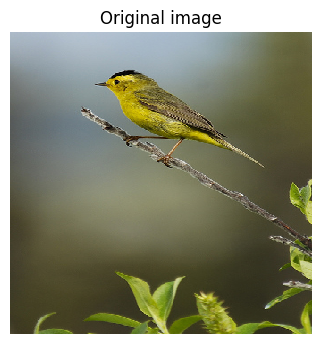

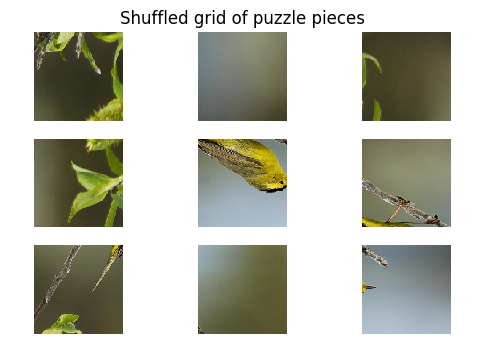

*****************
Solved puzzle using Dummy solver


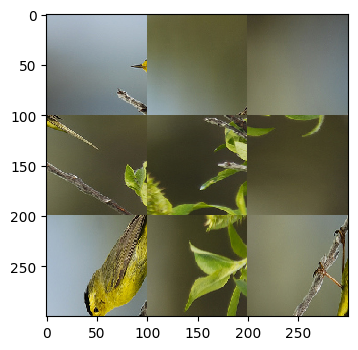

*******************
In correct position: 2
In correct position and rotation: 1


In [11]:
solve_example(my_image_file_name,my_puzzle_square_piece_dim,my_model_name, my_model,show_solving_progress=False,input_display=True)
    